## A worked-through example of word embeddings
Data from IMDB

### Preprocessing the labels of the raw IMDB data

In [1]:
import os

imdb_dir = '../data/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)    

### Tokenizing the text of the raw IMDB data
Pretrained word embeddings are meant to be particularly useful on problem where little training data is avilable
(otherwise, task-specific embeddings are likely to outperform them).

Restrict the training data to the first 200 samples.

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # Cuts off reviews after 100 words
training_samples = 200 # Train on 200 samples
validation_samples = 10000 # Validate on 10000 samples
max_words = 10000 # Consider only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

Using TensorFlow backend.


Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Parsing the GloVe word-embeddings file

In [3]:
glove_dir = '../data/glove.6B/'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) # 100-dim embedding for 400,000 words
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Preparing the GloVe word-embedding matrix
Build an embedding matrix that I can load into an `Embedding` layer. It must be a matrix of shape (`max_words`, `embedding_dim`), where each
entry `i` contains the `embedding-dim`-dimensional vector for the word of index $i$ in the reference word index (built during tokenization).
Note that index 0 isn't suppose to stand for any word or token - it's a placeholder.

In [4]:
embeddings_dim = 100

embedding_matrix = np.zeros((max_words, embeddings_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Defining a model

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embeddings_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model
Also, freeze the embedding layer, the pretrained parts shouldn't be updated during training
to avoid forgetting what they already know.

In [6]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [7]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10,
                   batch_size=32, validation_data=(x_val, y_val))

model.save_weights('pretrained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 1.5619 - acc: 0.5600 - val_loss: 1.6934 - val_acc: 0.4984
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6268 - acc: 0.6800 - val_loss: 1.0512 - val_acc: 0.5021
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3848 - acc: 0.7950 - val_loss: 0.9433 - val_acc: 0.5204
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3941 - acc: 0.8100 - val_loss: 0.7880 - val_acc: 0.5458
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1013 - acc: 0.9950 - val_loss: 2.5146 - val_acc: 0.4984
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3206 - acc: 0.8550 - val_loss: 0.7913 - val_acc: 0.5553
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0346 - acc: 1.0000 - val_loss: 0.8622 - val_acc: 0.5498
Epoch 8/10
200/200 [========

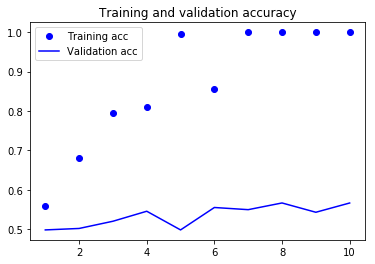

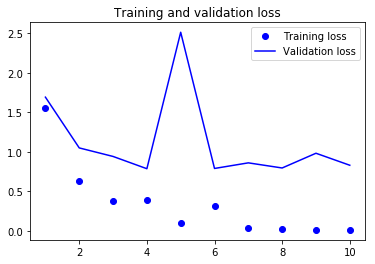

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

### Training the same model without pretrained word embeddings

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embeddings_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6927 - acc: 0.5200 - val_loss: 0.6904 - val_acc: 0.5314
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4971 - a

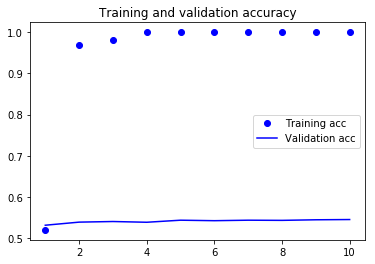

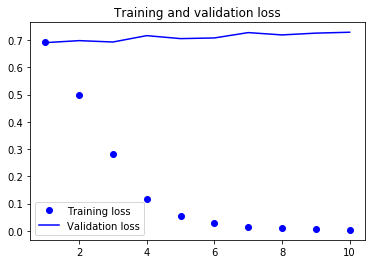

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

### Validate on the test set

In [11]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [13]:
model.load_weights('pretrained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 45us/step


[0.8441496541786194, 0.56424]

Working with just a handful of training samples is difficult!